In [1]:
from PIL import Image
from io import BytesIO
import matplotlib
#pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
#pip install numpy
import time

import torch
#conda install -c pytorch pytorch-cpu
import torch.optim as optim
import requests
from torchvision import transforms, models

In the above code all the necessary libraries are imported which will be used in the program for style transfer or are assumed that will be used in the following code. 

### AIM:

The aim for the follwing is to tranfer the style from the style image to the content image without loss in actual content of the image.

Generally content image is the one which has buildings,people,trees,or any type of scenery. And style image is the type of painting with some perticular texture or style.





#### Method :

To do the neural network style transfer vgg19 network is used with is the pretrained data of convolution neural network.

VGG19 is a variant of VGG model which in short consists of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer). There are other variants of VGG like VGG11, VGG16 and others. VGG19 has 19.6 billion FLOPs.

The algorithm used to otimize the losses (Content loss, Style loss) is "Adam". pytorch optim itself has this algorithm which optimises the loss.

Content Loss: 
The content loss,Essentially L_{content} captures the root mean squared error between the activations produced by the generated image and the content image.

Stle Loss:
style loss is also defined as a distance between two images. However, in order to apply a new style, style loss is defined as a distance between a style image and an output image.

In [2]:
def load_image(img_path, max_size=256, shape=None): # max size set to make the image small beacuse the processing time
                                                    # for larger image is lage.
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    #Vgg networks are normalized  with special values for the mean and std

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image


The above function is to load the image and convert that into tensor data after adding the batch dimention with it.

As vgg network is used in the code the images are normalized  with special values for the mean and std.

cnn_normalization_mean =(0.485, 0.456, 0.406)

cnn_normalization_std=(0.229, 0.224, 0.225)



In [3]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [4]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2', ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features



In [5]:
def gram_matrix(tensor):

    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

Why Gram Matrix ?

For Prisma-style effects, you would need to extract only texture information from the image. There is a number of ways to do that including Random Markov Field and Gram Matrix, based on VGG network. The simplest one is Gram matrix, that is basically (in an inner product space) the Hermitian matrix of inner products.

While this might look complicated, the actual realization is pretty simple. To get a style of image you would need to get a Gram Matrix (inner dot product) of vgg layer multiplied on transposed self. First, you vectorize (flatten) VGG layer content and then you do multiplication. Obtained matrix can be directly used to get style loss for training.

In [6]:
vgg = models.vgg19(pretrained=True).features

# freeze VGG params to avoid change
for param in vgg.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)


# load in content and style image
content = load_image('Resources/japanese_garden.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('Resources/picasso_selfportrait.jpg', shape=content.shape[-2:]).to(device)



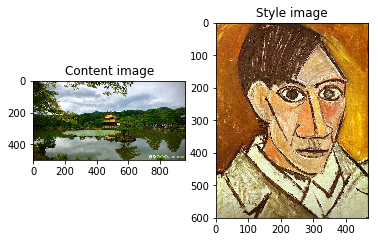

In [7]:
im1 = Image.open("Resources/japanese_garden.jpg")  
plt1=plt.subplot(1,2,1)
plt.title('Content image')
plt1.imshow(im1) 

im2 = Image.open("Resources/picasso_selfportrait.jpg")
plt2=plt.subplot(1,2,2)
plt.title('Style image')
plt2.imshow(im2) 

In [8]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003) # Adam algorithm used for optimization
itr = 50  # decide how many iterations to update your image 

In [9]:
for i in range(1, itr+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    if(i%5==0):
        print("Content loss for iteration "+str(i)+" : "+str(content_loss))
        print("Style loss for iteration "+str(i)+" : "+str(style_loss)) 
        print("Total loss for iteration "+str(i)+" : "+str(total_loss))
        print("----------------------------------------------------")
   
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

final = im_convert(target)
matplotlib.image.imsave('Output/final_output.jpg', final)


Content loss for iteration 5 : tensor(0.3432, grad_fn=<MeanBackward0>)
Style loss for iteration 5 : tensor(134.9353, grad_fn=<AddBackward0>)
Total loss for iteration 5 : tensor(1.3494e+08, grad_fn=<AddBackward0>)
----------------------------------------------------
Content loss for iteration 10 : tensor(1.1013, grad_fn=<MeanBackward0>)
Style loss for iteration 10 : tensor(121.6115, grad_fn=<AddBackward0>)
Total loss for iteration 10 : tensor(1.2161e+08, grad_fn=<AddBackward0>)
----------------------------------------------------
Content loss for iteration 15 : tensor(1.8909, grad_fn=<MeanBackward0>)
Style loss for iteration 15 : tensor(110.5576, grad_fn=<AddBackward0>)
Total loss for iteration 15 : tensor(1.1056e+08, grad_fn=<AddBackward0>)
----------------------------------------------------
Content loss for iteration 20 : tensor(2.6109, grad_fn=<MeanBackward0>)
Style loss for iteration 20 : tensor(101.4723, grad_fn=<AddBackward0>)
Total loss for iteration 20 : tensor(1.0147e+08, grad

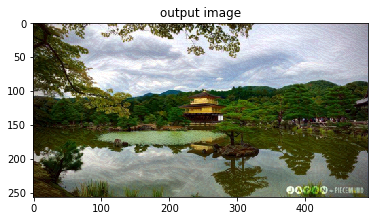

In [10]:
im = Image.open("Output/final_output.jpg")  
plt.title('output image')
plt.imshow(im) 